In [ ]:
pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.1 MB/s eta 0:00:00


In [ ]:
import random
import pandas as pd
from faker import Faker

# Initialize Faker
faker = Faker()

# Define possible values for Genres and Sentiment
genres = ["Fiction", "Non-fiction", "Fantasy", "Mystery", "Romance", "Science Fiction", "Thriller", "Biography", "History", "Children's"]
sentiments = ["Positive", "Neutral", "Negative"]

# Generate synthetic data
num_records = 14000
data = {
    "Title": [faker.sentence(nb_words=4) for _ in range(num_records)],
    "Author": [faker.name() for _ in range(num_records)],
    "Genres": [random.choice(genres) for _ in range(num_records)],
    "Sentiment": [random.choice(sentiments) for _ in range(num_records)],
    "Rating": [round(random.uniform(1.0, 5.0), 1) for _ in range(num_records)],
}

# Create a DataFrame
books_df = pd.DataFrame(data)

# Save to a CSV file
books_df.to_csv("synthetic_books1_dataset.csv", index=False)

print("Synthetic dataset created and saved as 'synthetic_books_dataset.csv'.")


Synthetic dataset created and saved as 'synthetic_books_dataset.csv'.


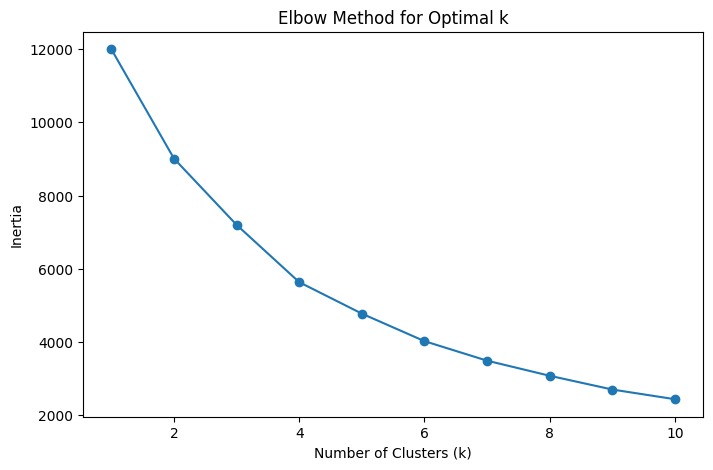

                                        Title           Author       Genres  \
0  Generation performance author fire future.  Breanna Leonard    Biography   
1                  Such of deep figure until.       Robert Ray      Fantasy   
2                        Happy affect toward.   Nicholas Ponce      History   
3               Might especially common list.   Kathryn Bailey  Non-fiction   
4                   Step run natural picture.  Michele Andrews      Mystery   

  Sentiment  Rating  Genres_encoded  Sentiment_encoded  Cluster  
0   Neutral     3.1               0                  1        1  
1  Negative     4.0               2                  0        0  
2  Negative     1.7               4                  0        2  
3   Neutral     3.7               6                  1        0  
4   Neutral     1.5               5                  1        2  
Clustered dataset saved as 'clustered_books_dataset.csv'.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# Load the synthetic dataset
data = pd.read_csv("synthetic_books_dataset.csv")

# Encode categorical columns (Genres and Sentiment) into numeric values
label_encoder_genres = LabelEncoder()
label_encoder_sentiment = LabelEncoder()

data['Genres_encoded'] = label_encoder_genres.fit_transform(data['Genres'])
data['Sentiment_encoded'] = label_encoder_sentiment.fit_transform(data['Sentiment'])

# Select features for clustering (Rating, Genres_encoded, Sentiment_encoded)
features = data[['Rating', 'Genres_encoded', 'Sentiment_encoded']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Use the Elbow Method to determine the optimal number of clusters
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means with the optimal number of clusters (e.g., 3)
optimal_k = 3  # Change based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Print a sample of the clustered dataset
print(data.head())

# Save the clustered dataset to a new CSV file
data.to_csv("clustered_books_dataset.csv", index=False)
print("Clustered dataset saved as 'clustered_books_dataset.csv'.")


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Load the synthetic dataset
data = pd.read_csv("synthetic_books_dataset.csv")

# Encode categorical columns (Genres and Sentiment) into numeric values
label_encoder_genres = LabelEncoder()
label_encoder_sentiment = LabelEncoder()

data['Genres_encoded'] = label_encoder_genres.fit_transform(data['Genres'])
data['Sentiment_encoded'] = label_encoder_sentiment.fit_transform(data['Sentiment'])

# Select features for clustering (Rating, Genres_encoded, Sentiment_encoded)
features = data[['Rating', 'Genres_encoded', 'Sentiment_encoded']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means with optimal clusters
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Save the clustered dataset
data.to_csv("clustered_books_dataset.csv", index=False)
print("Clustered dataset saved as 'clustered_books_dataset.csv'.")

# Filter books with high ratings (e.g., >= 4.0)
data_high_rating = data[data['Rating'] >= 4.0]

# Prepare dataset for classification
X = data_high_rating[['Genres_encoded', 'Cluster']]
y = data_high_rating['Title']  # Target is the book title for recommendation

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (e.g., Random Forest)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Save the model and encoders for reuse
import joblib
joblib.dump(classifier, "book_recommendation_model.pkl")
joblib.dump(label_encoder_genres, "genres_label_encoder.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")

print("Model and encoders saved for future use.")

# Function to recommend books based on user input
def recommend_books(user_genre):
    # Encode the user input genre
    user_genre_encoded = label_encoder_genres.transform([user_genre])[0]

    # Predict the cluster for the given genre
    cluster = kmeans.predict([[0, user_genre_encoded, 0]])[0]

    # Prepare input for the classifier
    user_input = np.array([[user_genre_encoded, cluster]])

    # Predict a book title based on user input
    recommended_books = classifier.predict(user_input)
    return recommended_books




Clustered dataset saved as 'clustered_books_dataset.csv'.
Model and encoders saved for future use.
Recommended books for genre 'Fiction': ['Such prove.']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Example usage
user_input_genre = "Fantasy"  # Example genre
recommended = recommend_books(user_input_genre)
print(f"Recommended books for genre '{user_input_genre}': {recommended}")

Recommended books for genre 'Fantasy': ['To ahead window arm.']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import joblib

# Load the clustered dataset
data = pd.read_csv("clustered_books_dataset.csv")

# Encode categorical columns (Genres and Sentiment) into numeric values
label_encoder_genres = LabelEncoder()
label_encoder_sentiment = LabelEncoder()
data['Genres_encoded'] = label_encoder_genres.fit_transform(data['Genres'])
data['Sentiment_encoded'] = label_encoder_sentiment.fit_transform(data['Sentiment'])

# Features and target for classification
X = data[['Genres_encoded', 'Cluster']]
y = data['Title']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
random_forest = RandomForestClassifier(random_state=42)
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
svm = SVC(probability=True, random_state=42)
knn = KNeighborsClassifier()

# Train and evaluate each classifier
classifiers = {
    "Random Forest": random_forest,
    "Logistic Regression": logistic_regression,
    "SVM": svm,
    "KNN": knn
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

# Ensemble: Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', random_forest),
        ('lr', logistic_regression),
        ('svm', svm),
        ('knn', knn)
    ],
    voting='hard'
)
ensemble_model.fit(X_train, y_train)

# Save models and encoders
joblib.dump(ensemble_model, "ensemble_recommendation_model.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(label_encoder_genres, "genres_label_encoder.pkl")

print("Ensemble model and encoders saved for future use.")

# Recommendation system with ensemble model
def recommend_books(user_genre):
    try:
        # Encode user input genre
        user_genre_encoded = label_encoder_genres.transform([user_genre])[0]

        # Predict cluster
        cluster = kmeans.predict([[0, user_genre_encoded, 0]])[0]

        # Prepare input for ensemble model
        user_input = np.array([[user_genre_encoded, cluster]])

        # Predict book title using the ensemble model
        recommended_titles = ensemble_model.predict(user_input)

        # Find details of recommended books
        recommendations = data[(data['Title'].isin(recommended_titles)) & (data['Cluster'] == cluster)]
        if not recommendations.empty:
            return recommendations[['Title', 'Genres', 'Rating', 'Author']]
        else:
            return "No book recommendations found for the provided input."
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Test with user inputs
user_inputs = ["Fiction", "Mystery", "Romance"]

print("\nBook Recommendations:")
for user_genre in user_inputs:
    print(f"\nFor Genre '{user_genre}':")
    recommendations = recommend_books(user_genre)
    print(recommendations)



Random Forest Classification Report:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

                                                      precision    recall  f1-score   support

                                        A statement.       0.00      0.00      0.00       1.0
                                Ability guy foreign.       0.00      0.00      0.00       1.0
                                       Able foreign.       0.00      0.00      0.00       1.0
                                   Able ready scene.       0.00      0.00      0.00       1.0
                           About lawyer can similar.       0.00      0.00      0.00       1.0
                               Above success region.       0.00      0.00      0.00       1.0
                        Above those professor their.       0.00      0.00      0.00       1.0
                Accept direction wonder federal one.       0.00      0.00      0.00       1.0
                     According most put agent major.       0.00      0.00      0.00       1.0
                                 Action institution.       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_


SVM Classification Report:

                                                      precision    recall  f1-score   support

                                        A statement.       0.00      0.00      0.00       1.0
                                Ability guy foreign.       0.00      0.00      0.00       1.0
                                       Able foreign.       0.00      0.00      0.00       1.0
                                   Able ready scene.       0.00      0.00      0.00       1.0
                           About lawyer can similar.       0.00      0.00      0.00       1.0
                               Above success region.       0.00      0.00      0.00       1.0
                        Above those professor their.       0.00      0.00      0.00       1.0
                Accept direction wonder federal one.       0.00      0.00      0.00       1.0
                     According most put agent major.       0.00      0.00      0.00       1.0
                              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import joblib

# Load datasets
data = pd.read_csv("synthetic_books_dataset.csv")  # Update with your file name

# 1. Data Cleaning
# Remove rows with missing values
data = data.dropna()

# Filter rows with realistic ratings (1.0 to 5.0)
data = data[(data['Rating'] >= 1.0) & (data['Rating'] <= 5.0)]

# Standardize text columns (strip whitespace, convert to lowercase)
data['Genres'] = data['Genres'].str.strip().str.lower()
data['Sentiment'] = data['Sentiment'].str.strip().str.lower()

# 2. Feature Engineering
# Encode categorical columns (Genres and Sentiment) into numeric values
label_encoder_genres = LabelEncoder()
label_encoder_sentiment = LabelEncoder()
data['Genres_encoded'] = label_encoder_genres.fit_transform(data['Genres'])
data['Sentiment_encoded'] = label_encoder_sentiment.fit_transform(data['Sentiment'])

# Features for clustering
features = data[['Rating', 'Genres_encoded', 'Sentiment_encoded']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# Save the clustered dataset
data.to_csv("clustered_books_dataset.csv", index=False)
print("Clustered dataset saved as 'clustered_books_dataset.csv'.")

# Filter books with high ratings (e.g., >= 4.0)
data_high_rating = data[data['Rating'] >= 4.0]

# 3. Prepare dataset for classification
X = data_high_rating[['Genres_encoded', 'Cluster']]
y = data_high_rating['Title']  # Target is the book title for recommendation

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
random_forest = RandomForestClassifier(random_state=42)
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
svm = SVC(probability=True, random_state=42)

# Ensemble: Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', random_forest),
        ('lr', logistic_regression),
        ('svm', svm)
    ],
    voting='hard'
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the model
y_pred = ensemble_model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Save models and encoders
joblib.dump(ensemble_model, "ensemble_recommendation_model.pkl")
joblib.dump(label_encoder_genres, "genres_label_encoder.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")

print("Ensemble model and encoders saved for future use.")

# 4. Recommendation System
def recommend_books(user_genre):
    try:
        # Encode user input genre
        user_genre_encoded = label_encoder_genres.transform([user_genre.lower().strip()])[0]

        # Predict cluster
        cluster = kmeans.predict([[0, user_genre_encoded, 0]])[0]

        # Prepare input for ensemble model
        user_input = np.array([[user_genre_encoded, cluster]])

        # Predict book title using the ensemble model
        recommended_titles = ensemble_model.predict(user_input)

        # Find details of recommended books
        recommendations = data[(data['Title'].isin(recommended_titles)) & (data['Cluster'] == cluster)]
        if not recommendations.empty:
            return recommendations[['Title', 'Genres', 'Rating', 'Author']]
        else:
            return "No book recommendations found for the provided input."
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Test with user inputs
user_inputs = ["Biography", "Fantasy"]

print("\nBook Recommendations:")
for user_genre in user_inputs:
    print(f"\nFor Genre '{user_genre}':")
    recommendations = recommend_books(user_genre)
    print(recommendations)


Clustered dataset saved as 'clustered_books_dataset.csv'.

Classification Report:

                                                precision    recall  f1-score   support

                     A hot structure election.       0.00      0.00      0.00       1.0
                            Able manage laugh.       0.00      0.00      0.00       1.0
                             Able ready scene.       0.00      0.00      0.00       1.0
                         Above success region.       0.00      0.00      0.00       1.0
                          Accept sort ok than.       0.00      0.00      0.00       0.0
Activity exist quite environmental conference.       0.00      0.00      0.00       1.0
                              After paper off.       0.00      0.00      0.00       1.0
            Again sound city yourself central.       0.00      0.00      0.00       1.0
                         Ago else why himself.       0.00      0.00      0.00       1.0
                       Agreement bro

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np

# Step 1: Load your dataset
books_df = pd.read_csv('/content/synthetic_books_dataset.csv')

# Step 2: Filter first 10 entries from the dataset
filtered_books = books_df.head(10)

# Step 3: Text Preprocessing for Clustering
filtered_books['text_data'] = filtered_books['Title'] + " " + filtered_books['Author'] + " " + filtered_books['Genres']

# Step 4: Vectorizing text data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(filtered_books['text_data'])

# Step 5: Encoding Ratings into classes
rating_bins = [0, 1, 2, 3, 4, 5]  # Adjust if needed
filtered_books['rating_class'] = pd.cut(filtered_books['Rating'], bins=rating_bins, labels=['c1', 'c2', 'c3', 'c4', 'c5'])

# Label Encoding for 'rating_class'
label_encoder = LabelEncoder()
filtered_books['rating_class'] = label_encoder.fit_transform(filtered_books['rating_class'])

# Prepare the dataset for training
X_features = X.toarray()  # Convert sparse matrix to dense
y_target = filtered_books['rating_class']

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

# Step 7: Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Step 8: Train and Evaluate models
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': confusion
    }

# Step 9: Compare models and print results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['classification_report'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("-" * 50)

# Step 10: Identify Best Model Based on Accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")
print(f"Best Model Accuracy: {results[best_model_name]['accuracy']:.4f}")

# Get Feature Importances or Coefficients for the best model
if best_model_name == "Random Forest" or best_model_name == "Gradient Boosting":
    importances = best_model.feature_importances_
    print("Feature Importances (for Random Forest / Gradient Boosting):")
    print(importances)
elif best_model_name == "Logistic Regression":
    coefficients = best_model.coef_
    print("Coefficients (for Logistic Regression):")
    print(coefficients)


<ipython-input-4-fa55a34ad543>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_books['text_data'] = filtered_books['Title'] + " " + filtered_books['Author'] + " " + filtered_books['Genres']
<ipython-input-4-fa55a34ad543>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_books['rating_class'] = pd.cut(filtered_books['Rating'], bins=rating_bins, labels=['c1', 'c2', 'c3', 'c4', 'c5'])
<ipython-input-4-fa55a34ad543>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Model: Logistic Regression
Accuracy: 0.5000
Classification Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, '2': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 1.0}, 'accuracy': 0.5, 'macro avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 2.0}, 'weighted avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 2.0}}
Confusion Matrix:
[[0 1]
 [0 1]]
--------------------------------------------------
Model: Decision Tree
Accuracy: 0.5000
Classification Report:
{'0': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 1.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, 'accuracy': 0.5, 'macro avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 2.0}, 'weighted avg': {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 2.0}}
Confusion Matrix:
[[1 0]
 [1 0]]
---

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the dataset (if the dataset is too large, you can sample a smaller portion)
books_df = pd.read_csv('/content/synthetic_books1_dataset.csv')

# Limit dataset size (Optional for faster computation)
# books_df = books_df.sample(n=10000, random_state=42)  # Sample 10,000 rows for faster testing

# Text Preprocessing for Clustering
books_df['text_data'] = books_df['Title'] + " " + books_df['Author'] + " " + books_df['Genres']

# Vectorizing text data (keeping it sparse to save memory)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit features for faster training
X = vectorizer.fit_transform(books_df['text_data'])

# Encoding Ratings into classes
rating_bins = [0, 1, 2, 3, 4, 5]
books_df['rating_class'] = pd.cut(books_df['Rating'], bins=rating_bins, labels=['c1', 'c2', 'c3', 'c4', 'c5'])
label_encoder = LabelEncoder()
books_df['rating_class'] = label_encoder.fit_transform(books_df['rating_class'])

# Prepare the dataset for training
X_features = X  # Keep sparse matrix format
y_target = books_df['rating_class']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

# Initialize simpler models (avoiding resource-intensive models like Random Forest and Gradient Boosting)
models = {
    "Logistic Regression": LogisticRegression(max_iter=100, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train and Evaluate models
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)  # Set zero_division to handle ill-defined precision
    confusion = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': confusion
    }

# Compare models and print results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['classification_report'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("-" * 50)

# Identify Best Model Based on Accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")
print(f"Best Model Accuracy: {results[best_model_name]['accuracy']:.4f}")

# Get Feature Importances or Coefficients for the best model
if best_model_name == "Decision Tree":
    importances = best_model.feature_importances_
    print("Feature Importances (for Decision Tree):")
    print(importances)
elif best_model_name == "Logistic Regression":
    coefficients = best_model.coef_
    print("Coefficients (for Logistic Regression):")
    print(coefficients)


Model: Logistic Regression
Accuracy: 0.2421
Classification Report:
{'0': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 38.0}, '1': {'precision': 0.24225352112676057, 'recall': 0.245014245014245, 'f1-score': 0.24362606232294617, 'support': 702.0}, '2': {'precision': 0.22519083969465647, 'recall': 0.26497005988023953, 'f1-score': 0.24346629986244842, 'support': 668.0}, '3': {'precision': 0.26214833759590794, 'recall': 0.2774018944519621, 'f1-score': 0.2695595003287311, 'support': 739.0}, '4': {'precision': 0.23754789272030652, 'recall': 0.18989280245022971, 'f1-score': 0.21106382978723404, 'support': 653.0}, 'accuracy': 0.24214285714285713, 'macro avg': {'precision': 0.3934281182275263, 'recall': 0.19545580035933527, 'f1-score': 0.19354313846027194, 'support': 2800.0}, 'weighted avg': {'precision': 0.25261994577741165, 'recall': 0.24214285714285713, 'f1-score': 0.23953219130457853, 'support': 2800.0}}
Confusion Matrix:
[[  0  10   8  14   6]
 [  0 172 190 210 130]
 [  0 1

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import joblib

# Load the dataset
books_df = pd.read_csv('/content/synthetic_books1_dataset.csv')

# Text Preprocessing for Clustering
books_df['text_data'] = books_df['Title'] + " " + books_df['Author'] + " " + books_df['Genres']

# Vectorizing text data (keeping it sparse to save memory)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit features for faster training
X = vectorizer.fit_transform(books_df['text_data'])

# Encoding Ratings into classes
rating_bins = [0, 1, 2, 3, 4, 5]
books_df['rating_class'] = pd.cut(books_df['Rating'], bins=rating_bins, labels=['c1', 'c2', 'c3', 'c4', 'c5'])
label_encoder = LabelEncoder()
books_df['rating_class'] = label_encoder.fit_transform(books_df['rating_class'])

# Prepare the dataset for training
X_features = X  # Keep sparse matrix format
y_target = books_df['rating_class']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

# Initialize models (avoiding resource-intensive models like Random Forest and Gradient Boosting)
models = {
    "Logistic Regression": LogisticRegression(max_iter=100, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train and Evaluate models
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    confusion = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': confusion
    }

# Compare models and print results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['classification_report'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("-" * 50)

# Identify Best Model Based on Accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")
print(f"Best Model Accuracy: {results[best_model_name]['accuracy']:.4f}")

# Save the best model and vectorizer
joblib.dump(best_model, f'{best_model_name}_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print(f"\nBest model, vectorizer, and label encoder saved to disk.")

# Optionally, to load the model for future predictions:
# loaded_model = joblib.load(f'{best_model_name}_model.pkl')
# loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')
# loaded_label_encoder = joblib.load('label_encoder.pkl')


Model: Logistic Regression
Accuracy: 0.2421
Classification Report:
{'0': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 38.0}, '1': {'precision': 0.24225352112676057, 'recall': 0.245014245014245, 'f1-score': 0.24362606232294617, 'support': 702.0}, '2': {'precision': 0.22519083969465647, 'recall': 0.26497005988023953, 'f1-score': 0.24346629986244842, 'support': 668.0}, '3': {'precision': 0.26214833759590794, 'recall': 0.2774018944519621, 'f1-score': 0.2695595003287311, 'support': 739.0}, '4': {'precision': 0.23754789272030652, 'recall': 0.18989280245022971, 'f1-score': 0.21106382978723404, 'support': 653.0}, 'accuracy': 0.24214285714285713, 'macro avg': {'precision': 0.3934281182275263, 'recall': 0.19545580035933527, 'f1-score': 0.19354313846027194, 'support': 2800.0}, 'weighted avg': {'precision': 0.25261994577741165, 'recall': 0.24214285714285713, 'f1-score': 0.23953219130457853, 'support': 2800.0}}
Confusion Matrix:
[[  0  10   8  14   6]
 [  0 172 190 210 130]
 [  0 1

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import joblib

# Load the dataset
books_df = pd.read_csv('/content/synthetic_books1_dataset.csv')  # Replace with your dataset path

# Text Preprocessing for Clustering
books_df['text_data'] = books_df['Title'] + " " + books_df['Author'] + " " + books_df['Genres']

# Vectorizing text data (keeping it sparse to save memory)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit features for faster training
X = vectorizer.fit_transform(books_df['text_data'])

# Encoding Ratings into classes
rating_bins = [0, 1, 2, 3, 4, 5]
books_df['rating_class'] = pd.cut(books_df['Rating'], bins=rating_bins, labels=['c1', 'c2', 'c3', 'c4', 'c5'])
label_encoder = LabelEncoder()
books_df['rating_class'] = label_encoder.fit_transform(books_df['rating_class'])

# Prepare the dataset for training
X_features = X  # Keep sparse matrix format
y_target = books_df['rating_class']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

# Initialize models (avoiding resource-intensive models like Random Forest and Gradient Boosting)
models = {
    "Logistic Regression": LogisticRegression(max_iter=100, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Train and Evaluate models
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    confusion = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': confusion
    }

# Compare models and print results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['classification_report'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("-" * 50)

# Identify Best Model Based on Accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")
print(f"Best Model Accuracy: {results[best_model_name]['accuracy']:.4f}")

# Save the best model and vectorizer
joblib.dump(best_model, f'{best_model_name}_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print(f"\nBest model, vectorizer, and label encoder saved to disk.")

# Optionally, to load the model for future predictions:
# loaded_model = joblib.load(f'{best_model_name}_model.pkl')
# loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')
# loaded_label_encoder = joblib.load('label_encoder.pkl')

# --------------------------- Prediction with Hardcoded Data ---------------------------

# Hardcoded data example (Genre: "Fantasy", Sentiment: "Neutral")
hardcoded_data = {
    "Title": "The Lost Kingdom",
    "Author": "John Doe",
    "Genres": "Fantasy",
    "Sentiment": "Neutral",
}

# Preprocess the hardcoded data
hardcoded_text = hardcoded_data['Title'] + " " + hardcoded_data['Author'] + " " + hardcoded_data['Genres']
hardcoded_data_vectorized = vectorizer.transform([hardcoded_text])  # Transform the text to feature vector

# Predict rating class using the best model
predicted_class = best_model.predict(hardcoded_data_vectorized)[0]

# Decode the predicted class back to the actual rating class
predicted_rating_class = label_encoder.inverse_transform([predicted_class])[0]

print(f"\nHardcoded Book Prediction:")
print(f"Title: {hardcoded_data['Title']}")
print(f"Author: {hardcoded_data['Author']}")
print(f"Genre: {hardcoded_data['Genres']}")
print(f"Sentiment: {hardcoded_data['Sentiment']}")
print(f"Predicted Rating Class: {predicted_rating_class}")


Model: Logistic Regression
Accuracy: 0.2421
Classification Report:
{'0': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 38.0}, '1': {'precision': 0.24225352112676057, 'recall': 0.245014245014245, 'f1-score': 0.24362606232294617, 'support': 702.0}, '2': {'precision': 0.22519083969465647, 'recall': 0.26497005988023953, 'f1-score': 0.24346629986244842, 'support': 668.0}, '3': {'precision': 0.26214833759590794, 'recall': 0.2774018944519621, 'f1-score': 0.2695595003287311, 'support': 739.0}, '4': {'precision': 0.23754789272030652, 'recall': 0.18989280245022971, 'f1-score': 0.21106382978723404, 'support': 653.0}, 'accuracy': 0.24214285714285713, 'macro avg': {'precision': 0.3934281182275263, 'recall': 0.19545580035933527, 'f1-score': 0.19354313846027194, 'support': 2800.0}, 'weighted avg': {'precision': 0.25261994577741165, 'recall': 0.24214285714285713, 'f1-score': 0.23953219130457853, 'support': 2800.0}}
Confusion Matrix:
[[  0  10   8  14   6]
 [  0 172 190 210 130]
 [  0 1

In [ ]:
import joblib
import pandas as pd

# Load the trained model, vectorizer, and label encoder
best_model = joblib.load('/content/Decision Tree_model.pkl')  # Change based on the best model saved
vectorizer = joblib.load('tfidf_vectorizer.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Load the dataset (if needed for finding related books)
books_df = pd.read_csv('/content/synthetic_books1_dataset.csv')  # Replace with the correct path

def predict_books_by_genre(user_genre):
    # Filter books based on the user input genre
    filtered_books = books_df[books_df['Genres'].str.contains(user_genre, case=False, na=False)]

    if filtered_books.empty:
        return "No books found for this genre. Please try a different genre."

    # Preprocess the filtered data (combine Title, Author, and Genre for prediction)
    filtered_books = filtered_books.copy()  # Avoid SettingWithCopyWarning
    filtered_books['text_data'] = filtered_books['Title'] + " " + filtered_books['Author'] + " " + filtered_books['Genres']

    # Vectorize the text data
    X_genre_input = vectorizer.transform(filtered_books['text_data'])

    # Predict the rating class for the books in the filtered genre
    predicted_classes = best_model.predict(X_genre_input)

    # Decode the predicted classes to numeric values (1-5 instead of c1-c5)
    predicted_rating_classes = [int(label.split('c')[1]) for label in label_encoder.inverse_transform(predicted_classes)]

    # Reset the index to align it with predicted_rating_classes
    filtered_books.reset_index(drop=True, inplace=True)

    # Add predicted numeric rating class to the DataFrame
    filtered_books['Predicted Rating Class'] = predicted_rating_classes

    # Sort by predicted rating class (highest first)
    sorted_books = filtered_books.sort_values(by='Predicted Rating Class', ascending=False)

    # Get the top 5 books
    top_books = sorted_books.head(5)

    # Prepare the results
    results = []
    for idx, book in top_books.iterrows():
        results.append({
            "Title": book['Title'],
            "Author": book['Author'],
            "Genre": book['Genres'],
            "Predicted Rating Class": book['Predicted Rating Class'],
        })

    return results

# User input for genre
user_genre = input("Enter a genre to get book recommendations: ")

# Get the predictions based on user input
predicted_books = predict_books_by_genre(user_genre)

# Display the results
if isinstance(predicted_books, str):
    print(predicted_books)  # If no books found, print the message
else:
    print(f"\nTop 5 Recommended Books for Genre: {user_genre.capitalize()}")
    for book in predicted_books:
        print(f"\nTitle: {book['Title']}")
        print(f"Author: {book['Author']}")
        print(f"Genre: {book['Genre']}")
        print(f"Predicted Rating Class: {book['Predicted Rating Class']}")


Enter a genre to get book recommendations: Fantasy

Top 5 Recommended Books for Genre: Fantasy

Title: Research song.
Author: Judy Rice
Genre: Fantasy
Predicted Rating Class: 5

Title: Color in see face national.
Author: Nicholas Wilson
Genre: Fantasy
Predicted Rating Class: 5

Title: Person PM director.
Author: Charles Fernandez
Genre: Fantasy
Predicted Rating Class: 5

Title: Radio the question.
Author: Ashley Rowe
Genre: Fantasy
Predicted Rating Class: 5

Title: Authority agent guess.
Author: Steven Campos
Genre: Fantasy
Predicted Rating Class: 5


In [ ]:
import pandas as pd
import joblib

# Load the saved model, vectorizer, and label encoder
best_model = joblib.load('/content/Decision Tree_model.pkl')  # Replace with the correct model name
vectorizer = joblib.load('tfidf_vectorizer.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Load the dataset (CSV with the columns you provided)
books_df = pd.read_csv('/content/clustered_books_dataset.csv')  # Path to the books dataset

# Ensure 'rating_class' is generated if it's missing
if 'rating_class' not in books_df.columns:
    # Encoding Ratings into classes
    rating_bins = [0, 1, 2, 3, 4, 5]
    books_df['rating_class'] = pd.cut(books_df['Rating'], bins=rating_bins, labels=['1', '2', '3', '4', '5'])
    label_encoder = joblib.load('label_encoder.pkl')  # Ensure the label encoder is used for inverse_transform

# Function to predict rating class and show books based on genre
def predict_and_display_books(genre):
    # Preprocess the input data (no title, no author, just genre and sentiment)
    text_data = f"Unknown Title Unknown Author {genre} Neutral"  # Combine title, author, genre, sentiment
    vectorized_data = vectorizer.transform([text_data])  # Vectorize the input data

    # Predict the rating class
    predicted_class = best_model.predict(vectorized_data)[0]

    # Decode the predicted class to actual rating class
    predicted_rating_class = label_encoder.inverse_transform([predicted_class])[0]

    # Find the books that match the genre and predicted rating class
    matching_books = books_df[(books_df['Genres'] == genre) & (books_df['rating_class'] == predicted_class)]

    # Display the results
    if not matching_books.empty:
        print(f"\nPredicted Rating Class for the genre '{genre}': {predicted_rating_class}")
        print("\nMatching Books and Authors:")
        for index, row in matching_books.iterrows():
            print(f"Book Title: {row['Title']}, Author: {row['Author']}, Rating: {row['Rating']}")
    else:
        print(f"\nNo books found for the genre '{genre}' with predicted rating class '{predicted_rating_class}'.")

# Get user input for genre
user_genre = input("Enter the book genre (e.g., Fantasy, Biography, Science Fiction): ").strip()

# Call the function to predict the rating class and display the books
predict_and_display_books(user_genre)


Enter the book genre (e.g., Fantasy, Biography, Science Fiction): Fantasy

No books found for the genre 'Fantasy' with predicted rating class 'c4'.
